In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import pydeck as pdk

import wetterdienst
import matplotlib.pyplot as plt
import pathlib
import joblib
import geopandas as gpd
import contextily as ctx


In [55]:
data = pathlib.Path("data")
cargo_tanker_wetter = joblib.load(data / "cargo_tanker_wetter.joblib").drop_duplicates()

### Analyse des zusammengesetzten Datensatzes

In [56]:
cargo_tanker_wetter.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2171176 entries, (Timestamp('2021-01-02 00:00:01'), 266420000) to (Timestamp('2021-01-02 23:59:58'), 255806262)
Data columns (total 47 columns):
 #   Column                                                                                       Dtype         
---  ------                                                                                       -----         
 0   latitude                                                                                     float64       
 1   longitude                                                                                    float64       
 2   navigational_status                                                                          object        
 3   rot                                                                                          float64       
 4   sog                                                                                          float64       
 5   cog      

In [57]:
cargo_tanker_wetter[["sea_surface_wind_wave_significant_height_unit_m"]].isna().describe()

sea_surface_wind_wave_significant_height_unit_m
count                                          2171176
unique                                               2
top                                              False
freq                                           2058941

Für Wind fehlen recht viele Einträge, daher füllen wir pro MMSI vorwärts und rücktwärts auf. 

In [58]:
cargo_tanker_wetter.groupby("mmsi").ffill().isna().describe()

latitude longitude navigational_status      rot      sog      cog  \
count   2171176   2171176             2171176  2171176  2171176  2171176   
unique        1         1                   1        1        1        1   
top       False     False               False    False    False    False   
freq    2171176   2171176             2171176  2171176  2171176  2171176   

        heading ship_type cargo_type    width  ... sampling_length_unit_1  \
count   2171176   2171176    2171176  2171176  ...                2171176   
unique        1         1          1        1  ...                      2   
top       False     False      False    False  ...                  False   
freq    2171176   2171176    2171176  2171176  ...                2049759   

       eastward_wind_unit_m s-1 wind_speed_unit_m s-1  \
count                   2171176               2171176   
unique                        2                     2   
top                       False                 False   
freq                    2049759               2049759   

       magnitude_of_surface_downward_stress_unit_Pa  \
count                                       2171176   
unique                                            2   
top                                           False   
freq                                        2049759   

       flag_-_0:ocean_-_1:earth/ice_unit_1  \
count                              2171176   
unique                                   2   
top                                  False   
freq                               2049759   

       surface_downward_northward_stress_unit_Pa  \
count                                    2171176   
unique                                         2   
top                                        False   
freq                                     2049759   

       northward_sea_water_velocity_unit_m s-1  \
count                                  2171176   
unique                                       2   
top                                      False   
freq                                   2161467   

       sea_water_potential_temperature_unit_degrees_C  \
count                                         2171176   
unique                                              2   
top                                             False   
freq                                          2161467   

       eastward_sea_water_velocity_unit_m s-1  \
count                                 2171176   
unique                                      2   
top                                     False   
freq                                  2161467   

       sea_surface_height_above_geoid_unit_m  
count                                2171176  
unique                                     2  
top                                    False  
freq                                 2161467  

[4 rows x 47 columns]

In [59]:
cargo_tanker_wetter = cargo_tanker_wetter.groupby("mmsi").ffill().groupby("mmsi").bfill()
cargo_tanker_wetter

latitude  longitude     navigational_status  \
timestamp           mmsi                                                      
2021-01-02 00:00:01 266420000  54.497382  11.551000  Under way using engine   
2021-01-02 00:00:04 245871000  56.823012  12.099355  Under way using engine   
                    240597000  57.426433   8.607067  Under way using engine   
2021-01-02 00:00:05 257787000  56.356855   3.895008  Under way using engine   
2021-01-02 00:00:06 205743000  57.574450   9.041350  Under way using engine   
...                                  ...        ...                     ...   
2021-01-02 23:59:58 257677000  57.683643   8.903580  Under way using engine   
                    636015737  55.864397  10.877138  Under way using engine   
                    209210000  56.058032  12.657232  Under way using engine   
                    230995000  55.475420   7.599495  Under way using engine   
                    255806262  57.678610   9.184613  Under way using engine   

                               rot   sog    cog  heading ship_type  \
timestamp           mmsi                                             
2021-01-02 00:00:01 266420000  0.0  12.0  296.6    296.0    Tanker   
2021-01-02 00:00:04 245871000  0.0  10.2  164.9    161.0     Cargo   
                    240597000  0.0  13.8   47.0     46.0    Tanker   
2021-01-02 00:00:05 257787000  0.0   0.8  159.3     32.0     Cargo   
2021-01-02 00:00:06 205743000 -1.1  16.0   57.4     57.0    Tanker   
...                            ...   ...    ...      ...       ...   
2021-01-02 23:59:58 257677000  0.0   8.2  280.4    280.0    Tanker   
                    636015737 -0.0  14.9   41.0     41.0    Tanker   
                    209210000  0.0  10.7  316.9    313.0    Tanker   
                    230995000 -1.1  18.2  300.5    302.0     Cargo   
                    255806262 -0.7  13.0  235.5    235.0    Tanker   

                                              cargo_type  width  ...  \
timestamp           mmsi                                         ...   
2021-01-02 00:00:01 266420000  No additional information   24.0  ...   
2021-01-02 00:00:04 245871000  No additional information   13.0  ...   
                    240597000  No additional information   27.0  ...   
2021-01-02 00:00:05 257787000  No additional information   21.0  ...   
2021-01-02 00:00:06 205743000  No additional information   30.0  ...   
...                                                  ...    ...  ...   
2021-01-02 23:59:58 257677000                 Category X   15.0  ...   
                    636015737                Category OS   26.0  ...   
                    209210000  No additional information   13.0  ...   
                    230995000  No additional information   24.0  ...   
                    255806262  No additional information   32.0  ...   

                               sampling_length_unit_1  \
timestamp           mmsi                                
2021-01-02 00:00:01 266420000                     1.0   
2021-01-02 00:00:04 245871000                     6.0   
                    240597000                    15.0   
2021-01-02 00:00:05 257787000                     5.0   
2021-01-02 00:00:06 205743000                    15.0   
...                                               ...   
2021-01-02 23:59:58 257677000                     7.0   
                    636015737                     1.0   
                    209210000                     1.0   
                    230995000                     6.0   
                    255806262                    19.0   

                               eastward_wind_unit_m s-1 wind_speed_unit_m s-1  \
timestamp           mmsi                                                        
2021-01-02 00:00:01 266420000                  0.469727              1.919922   
2021-01-02 00:00:04 245871000                 -3.429688              3.450195   
                    240597000                 -3.980469              5.809570   
2021-01-0

In [60]:
cargo_tanker_wetter.isna().describe()

latitude longitude navigational_status      rot      sog      cog  \
count   2171176   2171176             2171176  2171176  2171176  2171176   
unique        1         1                   1        1        1        1   
top       False     False               False    False    False    False   
freq    2171176   2171176             2171176  2171176  2171176  2171176   

        heading ship_type cargo_type    width  ... sampling_length_unit_1  \
count   2171176   2171176    2171176  2171176  ...                2171176   
unique        1         1          1        1  ...                      2   
top       False     False      False    False  ...                  False   
freq    2171176   2171176    2171176  2171176  ...                2145862   

       eastward_wind_unit_m s-1 wind_speed_unit_m s-1  \
count                   2171176               2171176   
unique                        2                     2   
top                       False                 False   
freq                    2145862               2145862   

       magnitude_of_surface_downward_stress_unit_Pa  \
count                                       2171176   
unique                                            2   
top                                           False   
freq                                        2145862   

       flag_-_0:ocean_-_1:earth/ice_unit_1  \
count                              2171176   
unique                                   2   
top                                  False   
freq                               2145862   

       surface_downward_northward_stress_unit_Pa  \
count                                    2171176   
unique                                         2   
top                                        False   
freq                                     2145862   

       northward_sea_water_velocity_unit_m s-1  \
count                                  2171176   
unique                                       2   
top                                      False   
freq                                   2170216   

       sea_water_potential_temperature_unit_degrees_C  \
count                                         2171176   
unique                                              2   
top                                             False   
freq                                          2170216   

       eastward_sea_water_velocity_unit_m s-1  \
count                                 2171176   
unique                                      2   
top                                     False   
freq                                  2170216   

       sea_surface_height_above_geoid_unit_m  
count                                2171176  
unique                                     2  
top                                    False  
freq                                 2170216  

[4 rows x 47 columns]

In [61]:
no_match = cargo_tanker_wetter[cargo_tanker_wetter["sampling_length_unit_1"].isna()]

In [62]:
gdf = gpd.GeoDataFrame(no_match, geometry=gpd.points_from_xy(no_match.longitude, no_match.latitude), crs="EPSG:4326")

In [63]:
match = cargo_tanker_wetter.query("~(sampling_length_unit_1.isna())")

In [64]:
samp = match.sample(100000)

In [65]:
samp_gdf = gpd.GeoDataFrame(samp, geometry=gpd.points_from_xy(samp.longitude, samp.latitude), crs="EPSG:4326")

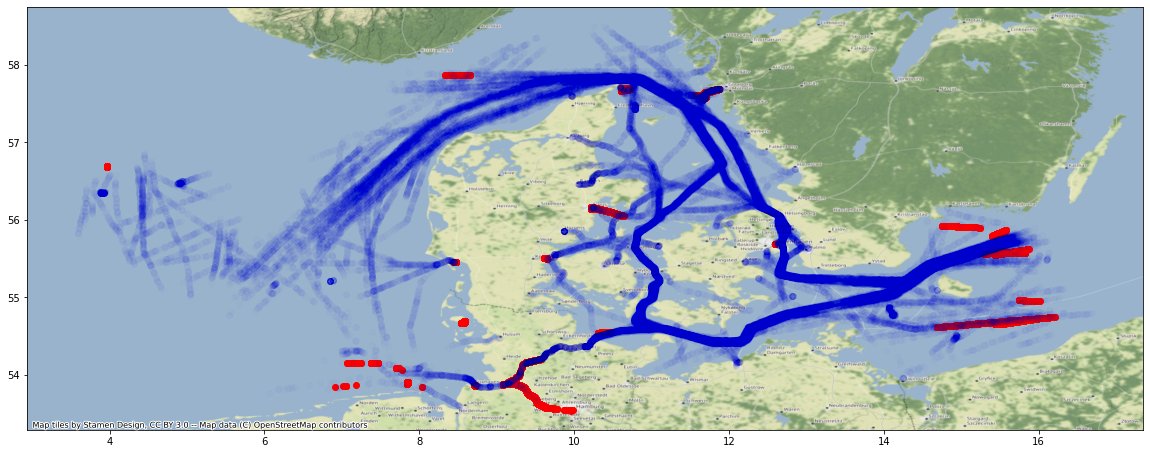

In [66]:
plt = gdf.plot(figsize=(20,20),color="red")
samp_gdf.plot(ax=plt, color="blue", alpha=0.01)
ctx.add_basemap(plt, crs=4326)

#### Visualisierungen

In [67]:
from shapely.geometry import Polygon
import h3.api.numpy_int as h3
 
def add_hexagon_geometry(row, h3_col):
    points = h3.h3_to_geo_boundary(
      row[h3_col], True)
    return Polygon(points)
 
samp['hexagon'] = samp.apply(add_hexagon_geometry, args=("h3_res_5",), axis=1)

weather_samp = no_match

weather_samp['hexagon'] = weather_samp.apply(add_hexagon_geometry, args=("h3_res_5",), axis=1)
wsamp = gpd.GeoDataFrame(weather_samp, geometry="hexagon", crs="EPSG:4326")

<ipython-input-67-1c16b18dc79f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_samp['hexagon'] = weather_samp.apply(add_hexagon_geometry, args=("h3_res_5",), axis=1)


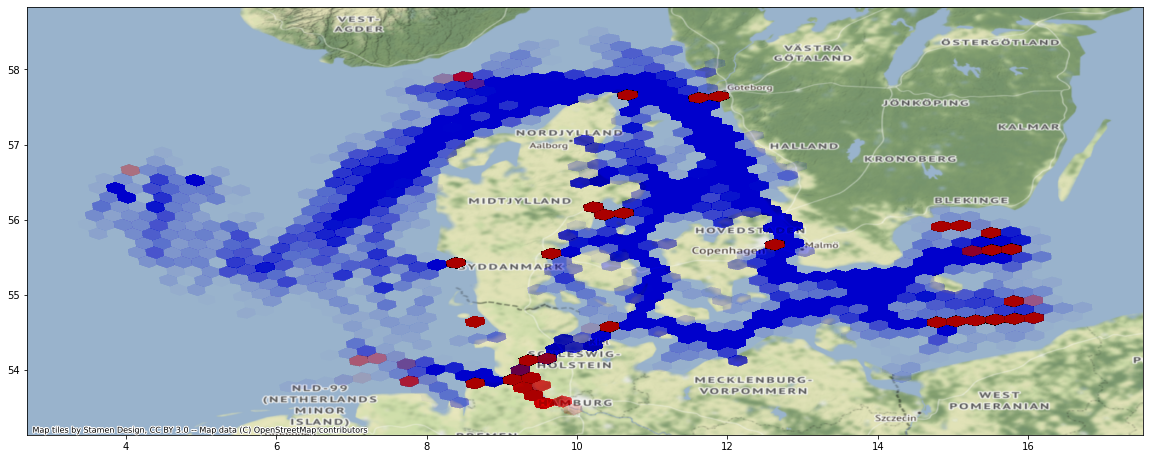

In [68]:
gdfsamp = gpd.GeoDataFrame(samp, geometry="hexagon", crs="EPSG:4326")
gdfsampplt = gdfsamp.plot(figsize=(20,20),color="blue", alpha=0.01)
wsamp.plot(ax=gdfsampplt, color="red", alpha=0.01)

ctx.add_basemap(gdfsampplt, crs=4326)

### Für wieviele Schiffe haben wir keine Wetterdaten?

In [69]:
no_match.reset_index().mmsi[~(no_match.reset_index().mmsi.isin(match.reset_index().mmsi))].nunique()

43

### Gesamt MMSIs im datensatz:

In [70]:

cargo_tanker_wetter.reset_index().mmsi.nunique()

594

### Null Rows droppen und Speichern

In [71]:
non_null = cargo_tanker_wetter.dropna()

In [72]:
non_null.isna().describe()

latitude longitude navigational_status      rot      sog      cog  \
count   2145278   2145278             2145278  2145278  2145278  2145278   
unique        1         1                   1        1        1        1   
top       False     False               False    False    False    False   
freq    2145278   2145278             2145278  2145278  2145278  2145278   

        heading ship_type cargo_type    width  ... sampling_length_unit_1  \
count   2145278   2145278    2145278  2145278  ...                2145278   
unique        1         1          1        1  ...                      1   
top       False     False      False    False  ...                  False   
freq    2145278   2145278    2145278  2145278  ...                2145278   

       eastward_wind_unit_m s-1 wind_speed_unit_m s-1  \
count                   2145278               2145278   
unique                        1                     1   
top                       False                 False   
freq                    2145278               2145278   

       magnitude_of_surface_downward_stress_unit_Pa  \
count                                       2145278   
unique                                            1   
top                                           False   
freq                                        2145278   

       flag_-_0:ocean_-_1:earth/ice_unit_1  \
count                              2145278   
unique                                   1   
top                                  False   
freq                               2145278   

       surface_downward_northward_stress_unit_Pa  \
count                                    2145278   
unique                                         1   
top                                        False   
freq                                     2145278   

       northward_sea_water_velocity_unit_m s-1  \
count                                  2145278   
unique                                       1   
top                                      False   
freq                                   2145278   

       sea_water_potential_temperature_unit_degrees_C  \
count                                         2145278   
unique                                              1   
top                                             False   
freq                                          2145278   

       eastward_sea_water_velocity_unit_m s-1  \
count                                 2145278   
unique                                      1   
top                                     False   
freq                                  2145278   

       sea_surface_height_above_geoid_unit_m  
count                                2145278  
unique                                     1  
top                                    False  
freq                                 2145278  

[4 rows x 47 columns]

In [78]:
non_null_sample = non_null.sample(20000)
non_null_sample['hexagon'] = non_null_sample.apply(add_hexagon_geometry, args=("h3_res_5",), axis=1)
gdfsamp = gpd.GeoDataFrame(non_null_sample, geometry="hexagon", crs="EPSG:4326")

c:\users\deeman\appdata\local\pypoetry\cache\virtualenvs\aisfeel-wcuqt8d_-py3.8\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


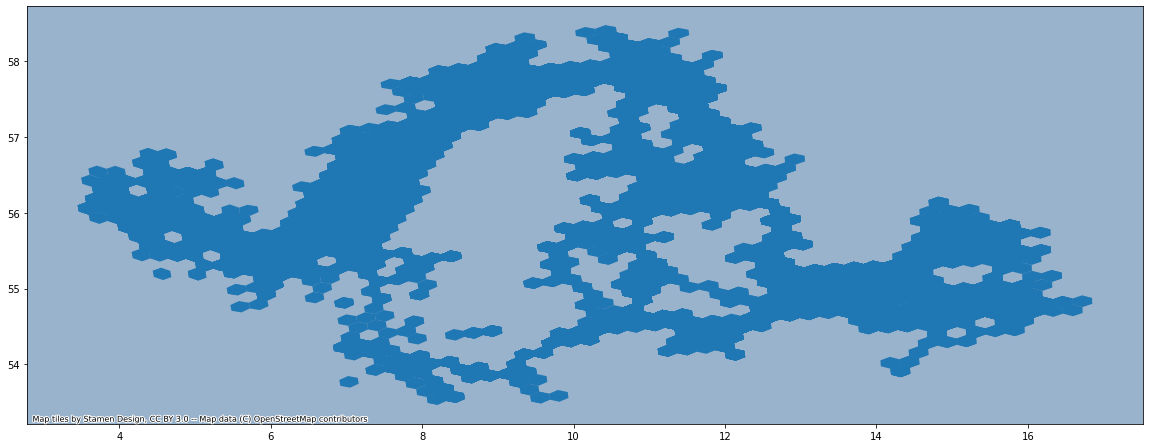

In [79]:
nplot = gdfsamp.plot(figsize=(20,20))
ctx.add_basemap(nplot)

In [76]:
joblib.dump(non_null, data / "cargo_tanker_wetter_cleaned.joblib")

['data\\cargo_tanker_wetter_cleaned.joblib']